In [3]:
import pandas as pd

df = pd.read_csv('result\공공데이터_POI_카테고리완성_최종.csv')

print(df.columns)

Index(['id', 'name', 'x', 'y', 'category_2nd', 'category_1st',
       'category_code'],
      dtype='object')


In [4]:
category_counts = df['category_1st'].value_counts()
print(category_counts)

category_1st
음식점        2514
버스정류장      1515
중개업소       1145
카페         1086
생활서비스       937
문화시설        428
병원          401
편의점         346
약국          160
공공기관        124
숙박           79
주유소,충전소      69
대형마트          4
Name: count, dtype: int64


<>:11: SyntaxWarning: invalid escape sequence '\B'
<>:14: SyntaxWarning: invalid escape sequence '\L'
<>:11: SyntaxWarning: invalid escape sequence '\B'
<>:14: SyntaxWarning: invalid escape sequence '\L'
C:\Users\dodam\AppData\Local\Temp\ipykernel_22840\291641906.py:11: SyntaxWarning: invalid escape sequence '\B'
  gdf_dong = gpd.read_file("data\BND_ADM_DONG_PG\BND_ADM_DONG_PG.shp", encoding="euc-kr")
C:\Users\dodam\AppData\Local\Temp\ipykernel_22840\291641906.py:14: SyntaxWarning: invalid escape sequence '\L'
  gdf_sgg = gpd.read_file("data\LARD_ADM_SECT_SGG_세종\LARD_ADM_SECT_SGG_36_202504.shp", encoding="euc-kr")
C:\Users\dodam\AppData\Local\Temp\ipykernel_22840\291641906.py:34: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_dong_sejong_boundary = gdf_dong_sejong.boundary.unary_union


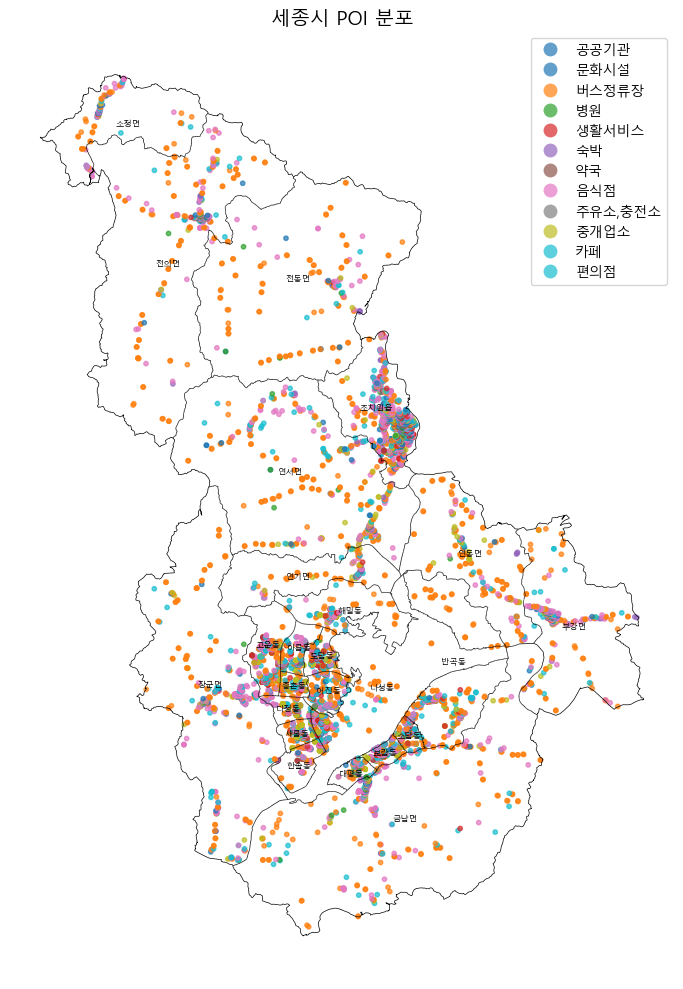

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ▶ 한글 깨짐 방지: 맑은 고딕 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ▶ 1. 행정동 경계 (전국)
gdf_dong = gpd.read_file("data\BND_ADM_DONG_PG\BND_ADM_DONG_PG.shp", encoding="euc-kr")

# ▶ 2. 세종시 시군구 경계
gdf_sgg = gpd.read_file("data\LARD_ADM_SECT_SGG_세종\LARD_ADM_SECT_SGG_36_202504.shp", encoding="euc-kr")

# ▶ 3. 좌표계 맞추기
gdf_dong = gdf_dong.to_crs(epsg=5181)
gdf_sgg = gdf_sgg.to_crs(epsg=5181)

# ▶ 4. 세종시 영역으로 clip
gdf_dong_sejong = gpd.clip(gdf_dong, gdf_sgg)
gdf_dong_sejong = gdf_dong_sejong[gdf_dong_sejong["ADM_CD"].astype(str).str.startswith("29010")]


# ▶ 5. POI 불러오기
df_poi = pd.read_csv("result/세종특별자치시_POI_최종.csv")
gdf_poi = gpd.GeoDataFrame(
    df_poi,
    geometry=gpd.points_from_xy(df_poi["x"], df_poi["y"]),
    crs="EPSG:4326"
).to_crs(epsg=5181)

# 행정동 경계 라인 중첩 제거 (경계선 단순화)
gdf_dong_sejong_boundary = gdf_dong_sejong.boundary.unary_union
gdf_dong_sejong_boundary = gpd.GeoSeries(gdf_dong_sejong_boundary, crs=gdf_dong_sejong.crs)
gdf_poi = gpd.clip(gdf_poi, gdf_sgg)

# ▶ 6. 시각화
fig, ax = plt.subplots(figsize=(10, 10))

# ✅ 단일 경계선으로 그림
gdf_dong_sejong_boundary.plot(ax=ax, color='black', linewidth=0.5)

# POI
gdf_poi.plot(
    ax=ax,
    column="category_1st",
    categorical=True,
    legend=True,
    markersize=10,
    alpha=0.7
)

plt.title("세종시 POI 분포", fontsize=14)
plt.axis("off")

# ▶ 행정동 라벨 표시
for idx, row in gdf_dong_sejong.iterrows():
    centroid = row.geometry.centroid
    label = row["ADM_NM"]
    ax.text(centroid.x, centroid.y, label, fontsize=6, ha='center', va='center')

plt.tight_layout()
plt.show()

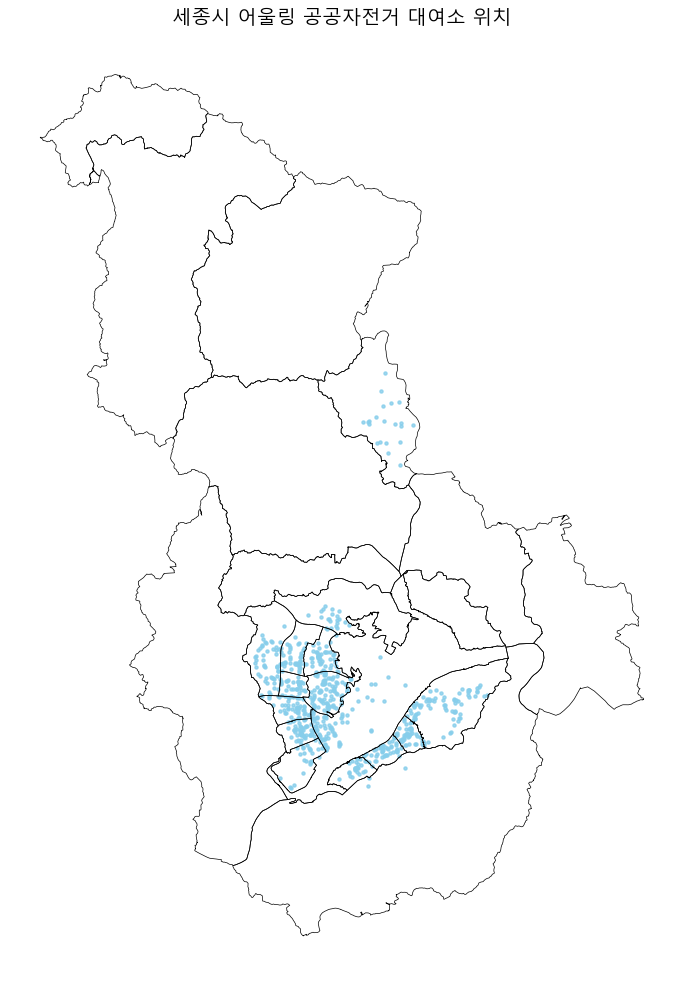

In [65]:
# ▶ 전체 지도
fig, ax = plt.subplots(figsize=(10, 10))
gdf_dong_sejong.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf_bike.plot(ax=ax, color='skyblue', markersize=5, label="공공자전거 대여소", alpha=0.8)

ax.set_title("세종시 어울링 공공자전거 대여소 위치", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

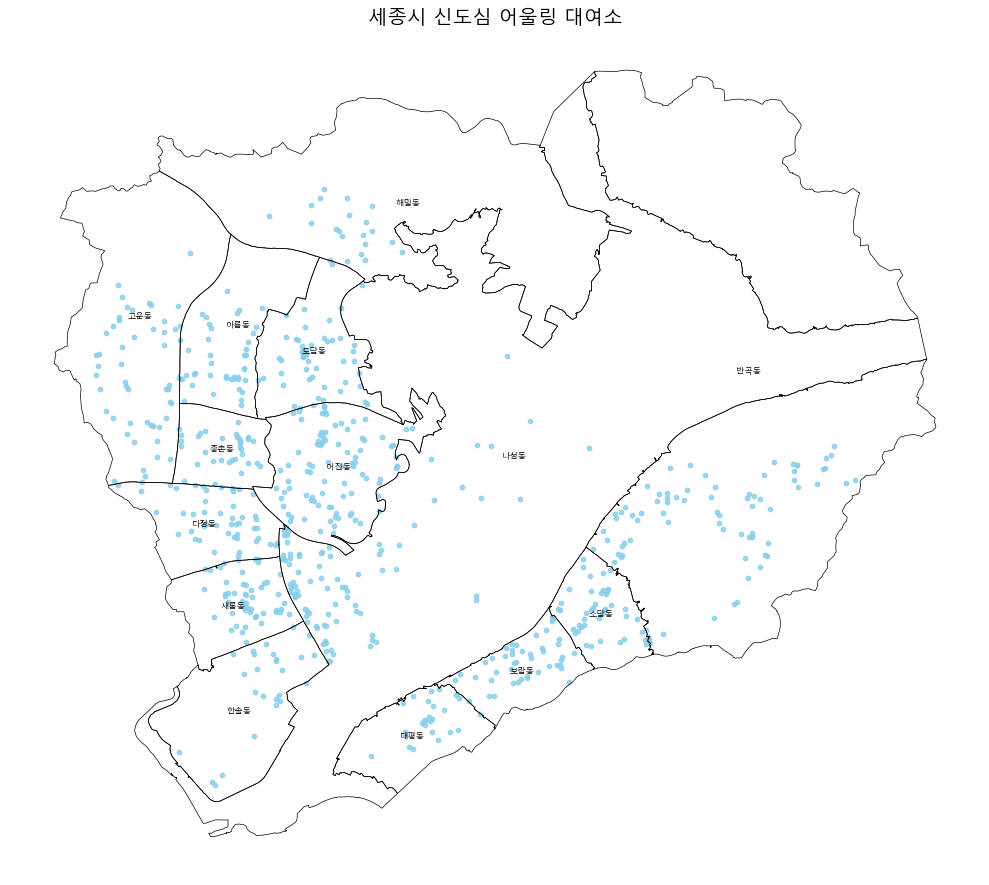

In [81]:
# ▶ 신도심을 구성하는 주요 행정동 이름
newtown_dongs = ["누리동", "한별동", "도담동", "보람동", "아름동", "새롬동", "나성동", "고운동", "한솔동", "대평동", "해밀동", "어진동", "종촌동", "다정동", "집현동", "반곡동", "소담동"]

# ▶ 해당 행정동만 추출
gdf_dong_newtown = gdf_dong_sejong[gdf_dong_sejong["ADM_NM"].isin(newtown_dongs)]

# ▶ 대여소 중 해당 행정동 내에 포함된 것만 추출
gdf_bike_newtown = gpd.sjoin(gdf_bike, gdf_dong_newtown, predicate="within")

# ▶ 신도심 지도
fig, ax = plt.subplots(figsize=(10, 10))
gdf_dong_newtown.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf_bike_newtown.plot(ax=ax, color='skyblue', markersize=10, alpha=0.8)

ax.set_title("세종시 신도심 어울링 대여소", fontsize=14)
ax.axis("off")

# ✅ 신도심 행정동만 라벨 표시
for idx, row in gdf_dong_newtown.iterrows():
    centroid = row.geometry.centroid
    label = row["ADM_NM"]
    ax.text(centroid.x, centroid.y, label, fontsize=6, ha='center', va='center')

plt.tight_layout()
plt.show()


In [72]:
jcw_dong = ["조치원읍"]

# 신도심과 조치원 영역 추출
gdf_dong_newtown = gdf_dong_sejong[gdf_dong_sejong["ADM_NM"].isin(newtown_dongs)]
gdf_dong_jcw = gdf_dong_sejong[gdf_dong_sejong["ADM_NM"].isin(jcw_dong)]

# 신도심 내 대여소 추출
gdf_bike_newtown = gpd.sjoin(gdf_bike, gdf_dong_newtown, predicate="within", how="inner")

# 조치원 내 대여소 추출
gdf_bike_jcw = gpd.sjoin(gdf_bike, gdf_dong_jcw, predicate="within", how="inner")

print("전체 대여소 개수:", len(gdf_bike))
print("신도심 내 대여소 개수:", len(gdf_bike_newtown))
print("조치원 내 대여소 개수:", len(gdf_bike_jcw))

전체 대여소 개수: 712
신도심 내 대여소 개수: 688
조치원 내 대여소 개수: 21


C:\Users\dodam\AppData\Local\Temp\ipykernel_22840\1746562312.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  within_mask = grid_gdf.within(gdf_sejong.unary_union)


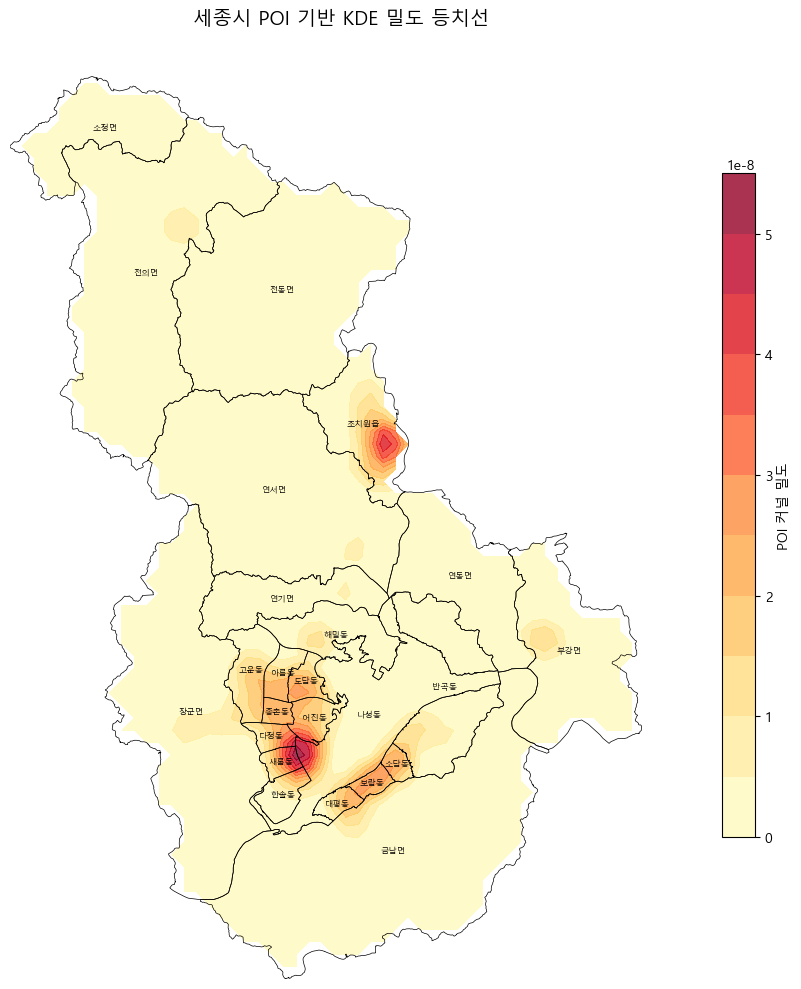

In [78]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point

# ▶ 1. POI 불러오기 및 좌표계 변환
df_poi = pd.read_csv("result/세종특별자치시_POI.csv")
gdf_poi = gpd.GeoDataFrame(
    df_poi,
    geometry=gpd.points_from_xy(df_poi["x"], df_poi["y"]),
    crs="EPSG:4326"
).to_crs(epsg=5181)

# ▶ 2. 세종시 경계 불러오기 (ADM_CD로 필터)
gdf_dong = gpd.read_file("data/BND_ADM_DONG_PG/BND_ADM_DONG_PG.shp", encoding="euc-kr").to_crs(epsg=5181)
gdf_sejong = gdf_dong[gdf_dong["ADM_CD"].astype(str).str.startswith("29010")]

# ▶ 3. POI 클리핑
gdf_poi = gpd.clip(gdf_poi, gdf_sejong)

# ▶ 4. KDE 좌표 준비
coords = np.vstack([gdf_poi.geometry.x, gdf_poi.geometry.y]).T

# ▶ 5. 격자 생성 (500m 해상도)
xmin, ymin, xmax, ymax = gdf_sejong.total_bounds
cell_size = 500
xx, yy = np.meshgrid(
    np.arange(xmin, xmax, cell_size),
    np.arange(ymin, ymax, cell_size)
)
grid_coords = np.vstack([xx.ravel(), yy.ravel()]).T

# ▶ 6. KDE 학습 (대역폭 1000m)
kde = KernelDensity(kernel='epanechnikov', bandwidth=1000)
kde.fit(coords)
log_dens = kde.score_samples(grid_coords)
density = np.exp(log_dens).reshape(xx.shape)

# ▶ 7. 마스킹: 세종시 외부는 가리기
grid_points = [Point(x, y) for x, y in zip(xx.ravel(), yy.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points, crs="EPSG:5181")
within_mask = grid_gdf.within(gdf_sejong.unary_union)
masked_density = np.ma.masked_where(~within_mask.values.reshape(xx.shape), density)

# ▶ 8. 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf_sejong.boundary.plot(ax=ax, color='black', linewidth=0.5)

# KDE 등치선 (세종시 내부만 표시)
contour = ax.contourf(xx, yy, masked_density, levels=10, cmap="YlOrRd", alpha=0.8)

# 컬러바
cbar = plt.colorbar(contour, ax=ax, shrink=0.7)
cbar.set_label("POI 커널 밀도")


plt.title("세종시 POI 기반 KDE 밀도 등치선", fontsize=14)
plt.axis("off")

for idx, row in gdf_dong_sejong.iterrows():
    centroid = row.geometry.centroid
    label = row["ADM_NM"]
    ax.text(centroid.x, centroid.y, label, fontsize=6, ha='center', va='center')
    
plt.tight_layout()
plt.show()